# Access to dry matter productivity from Copernicus Global Land Service (CGLS)

This script extracts single pixel time series and saves it as table .csv

**Follow up actions**
- filter by RT (~reprocessing time): RT5 (before 2020) and RT6 (2021 onwards) are the best quality
- check quality flags
    - QFLAG == 0 means good quality
- convert units [DMP is in kg DM m-2 day-1]:
    - NPP [g C m-2 day-1] = DMP [kg DM m-2 day-1]  * 0.045
    - GPP [g C m-2 day-1] = NPP [g C m-2 day-1] * 2
    
(c) Egor Prikaziuk, prikaziuk@gmail.com

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray

from pathlib import Path

## Single image example

In [2]:
dmp_path = Path(r"/data/MTDA/BIOPAR/BioPar_DMP300_V1_Global/2021/20211031/c_gls_DMP300-RT0_202110310000_GLOBE_OLCI_V1.1.1/")

In [3]:
lat_i = 5.7413
lon_i = 21.5931

In [4]:
nc = xarray.open_dataset(next(dmp_path.glob('*.nc')))

Spatial subset +/- 1 degree around the point

**Do not try plotting the whole image, the file is bigger than the RAM available**

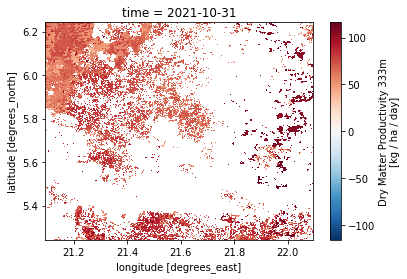

In [6]:
nc_subset = nc.sel(lon=slice(lon_i-0.5, lon_i+0.5), lat=slice(lat_i+0.5, lat_i-0.5)).squeeze();
nc_subset.DMP.plot.imshow()
# nc_subset.to_netcdf('subset.nc')  # export example

In [7]:
nc.sel(lat=lat_i, lon=lon_i, method='nearest').to_dataframe()  # pixel extraction

,DMP,QFLAG,crs,lat,lon
time,,,,,
2021-10-31,NaN,1.0,b'',5.741071,21.592262


## Multiple images in a loop
takes ca 5 minutes to run for DMP300 2017-2021

In [18]:
lat_i = 5.7413
lon_i = 21.5931
year_of_start = 2020  # to speed up, DMP300 starts in 2017, DMP1000 in 1999

In [21]:
dmp300 = Path(r"/data/MTDA/BIOPAR/BioPar_DMP300_V1_Global")
# 2021/20211031/c_gls_DMP300-RT0_202110310000_GLOBE_OLCI_V1.1.1/"  # example of filenames convention

df_out = pd.DataFrame()
for nc_path in dmp300.glob('**/*.nc'):
    
    print('.', end='')
    year_i = int(nc_path.parent.parent.parent.name)
    if year_i < year_of_start:
        continue
        
    nc_i = xarray.open_dataset(nc_path)
    pix_i = nc_i.sel(lat=lat_i, lon=lon_i, method='nearest').to_dataframe()
    pix_i['RT'] = nc_path.name.split('_')[2].split('-')[1]
    df_out = df_out.append(pix_i, sort=True)

...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Saving

In [27]:
df_out.to_csv(f'DMP300_[{lon_i},{lat_i}].csv')
# df_out[df_out.rt.isin(['RT5', 'RT6'])].DMP.multiply(0.045).sort_index().to_csv('NPP300_[5.74,21.59].csv')

### The effect of RT

Text(0.5, 1.0, 'CGLS: effect of RT')

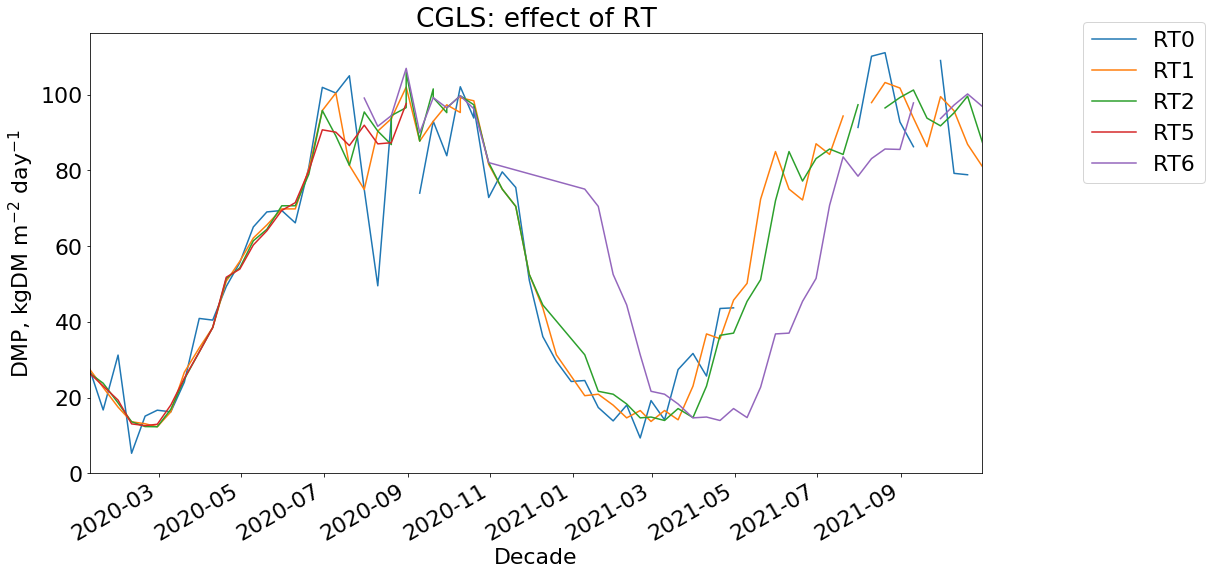

In [26]:
plt.rcParams.update({'font.size': 22})
df_out.groupby('RT').DMP.plot(figsize=(16, 9))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylabel(r'DMP, kgDM m$^{-2}$ day$^{-1}$')
plt.xlabel('Decade')
plt.title('CGLS: effect of RT')
# plt.savefig('cgls_RT_effect.png', bbox_inches="tight")